In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

!pip install tensorflow-gpu==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#Importing Skin Cancer Data
#To do: Take necessary actions to read the data


In [3]:
!nvidia-smi

Tue May  9 12:19:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

Actinic keratosis

Basal cell carcinoma

Dermatofibroma

Melanoma

Nevus

Pigmented benign keratosis

Seborrheic keratosis

Squamous cell carcinoma

Vascular lesion

In [4]:
##import all important file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from tensorflow.keras.losses import binary_crossentropy
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [5]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/ColabNotebooks/Datasets/Skin_Cancer_Data/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/ColabNotebooks/Datasets/Skin_Cancer_Data/Test")

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)


2239
118


#Load using keras.preprocessing
let's load these images off disk using the helpful image_dataset_from_directory utility.

create a dataset Define some parameter for the loader:



In [8]:
batch_size=32
img_height=180
img_width=180

In [9]:
# write  train dataset here
# Note use seed=123 while creating  dataset using tf.keras.preprocessing.image_dataset_from_directory
# Note,resize images to the size img_height*img _width,while writing the dataset 
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset= "training", 
    image_size=(img_height,img_width),
    batch_size= batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
# write validation dataset here
# Note use seed =123 while creating  dataset tf.keras.preprocessing.image_dataset_from_directory
# Note, resize  images to the  size img_height*img_width, while writing the dataset
validation_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed= 123,
    validation_split= 0.2,
    subset= 'validation',
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
  # find the all class_names 
all_classes_names= train_ds.class_names
print(all_classes_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#Visualize the dataset
create a code to visualize one instance of all the nine classes present in te dataset



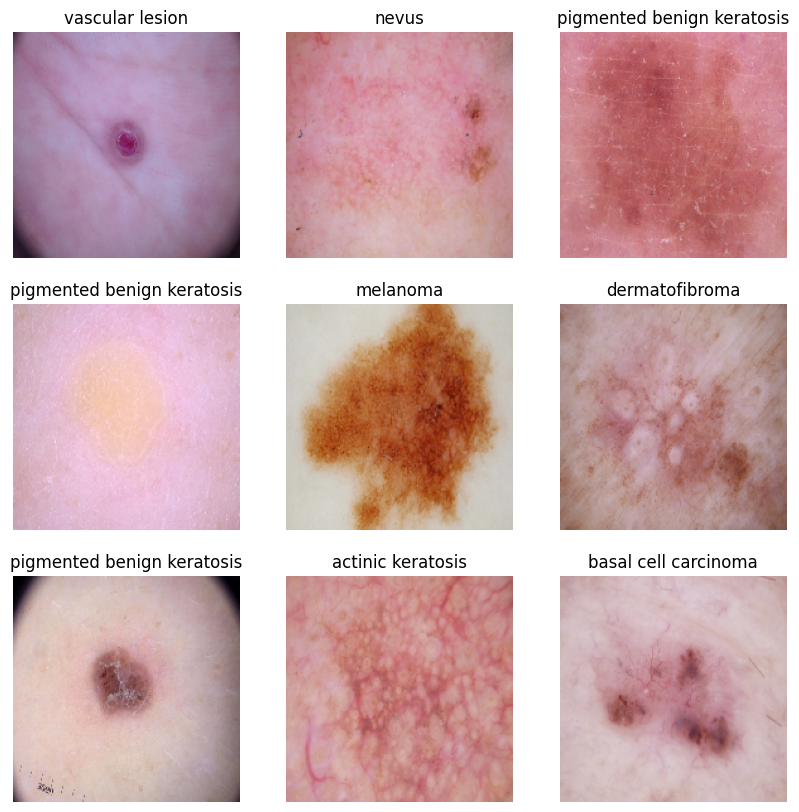

In [12]:
plt.figure(figsize=(10,10))
for image, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(all_classes_names[labels[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

#Create the model
create a CNN model,which can accurately detect 9 classes present in the dataset.use layers.experimental.preprocessing.Recaling to normalize pixel values between (0,1). the RGB channel values are in the [0,255] range.this is not ideal for a neural network.here, it is good to standardize values to be in the [0,1]

In [13]:
preprocessing_layers=[tf.keras.layers.experimental.preprocessing.Rescaling(1./ 255, input_shape =(180,180,3))]

In [14]:
#code
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#Compile the model
choose an appropirate optimiser and loss function

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

#Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 163s 3s/step - loss: 2.0533 - accuracy: 0.1836 - val_loss: 2.0634 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 19s 312ms/step - loss: 2.0292 - accuracy: 0.2059 - val_loss: 2.0304 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 19s 312ms/step - loss: 2.0272 - accuracy: 0.2093 - val_loss: 2.0440 - val_accuracy: 0.2192
Epoch 4/20
56/56 [==============================] - 21s 314ms/step - loss: 1.9990 - accuracy: 0.2232 - val_loss: 1.9613 - val_accuracy: 0.2528
Epoch 5/20
56/56 [==============================] - 19s 303ms/step - loss: 1.9794 - accuracy: 0.2260 - val_loss: 1.9854 - val_accuracy: 0.2349
Epoch 6/20
56/56 [==============================] - 19s 305ms/step - loss: 1.9564 - accuracy: 0.2533 - val_loss: 2.0826 - val_accuracy: 0.2461
Epoch 7/20
56/56 [==============================] - 19s 312ms/step - loss: 1.9702 - accuracy: 0.2193 - val_loss: 2.0157 - val_accuracy: 0.2371
Epoch 8/20
5

Write your findings after the model fit, see if there is an evidence of model overfit or underfit
Finding on the first base model

The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

The accuracy is just around 75-80% because there are enough features to remember the pattern.

But again, it's too early to comment on the overfitting & underfitting debate



In [18]:
# Todo, after  analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

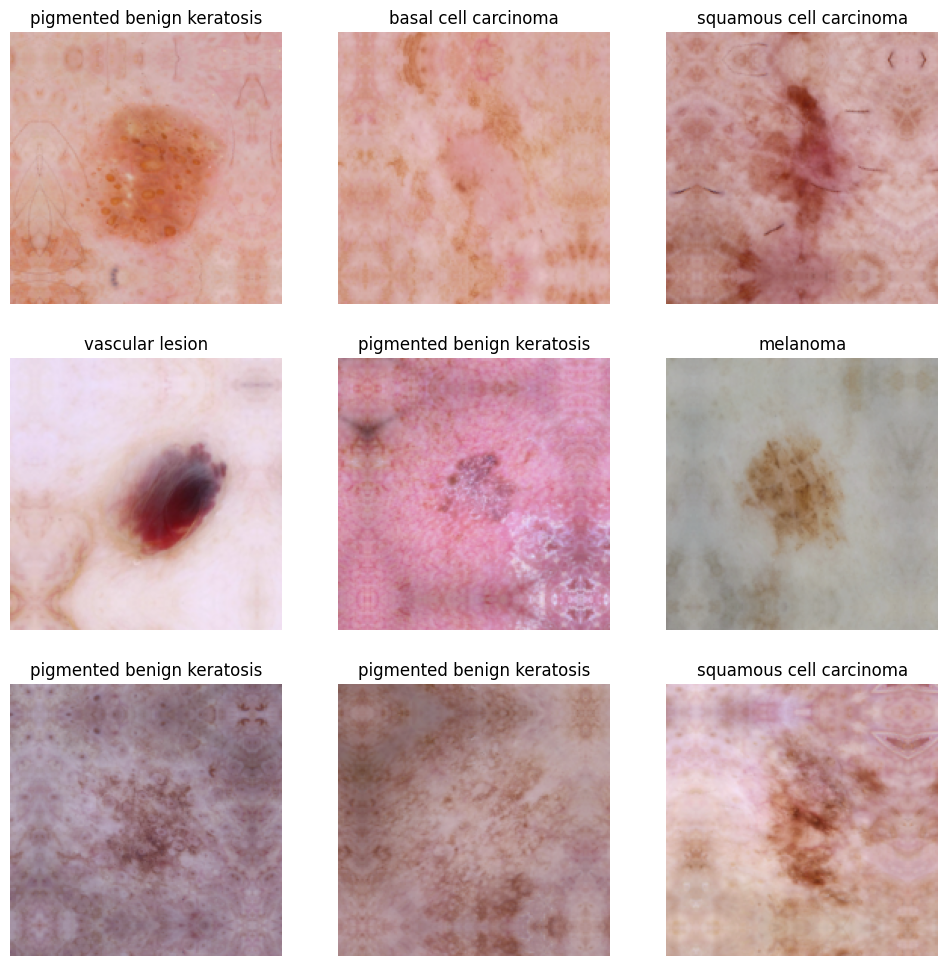

In [19]:
# Todo, visualize how augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(all_classes_names[labels[i]])
        plt.axis("off")

Create the model, compile and train the model

In [20]:
## use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

Compiling the model

In [21]:
### code here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model

code for epochs = 30

In [22]:

epochs=30
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/30


56/56 [==============================] - 37s 499ms/step - loss: 2.0506 - accuracy: 0.2109 - val_loss: 1.8984 - val_accuracy: 0.2886
Epoch 2/30
56/56 [==============================] - 28s 457ms/step - loss: 1.9799 - accuracy: 0.2483 - val_loss: 2.0892 - val_accuracy: 0.1611
Epoch 3/30
56/56 [==============================] - 30s 493ms/step - loss: 2.0413 - accuracy: 0.2070 - val_loss: 2.0308 - val_accuracy: 0.2103
Epoch 4/30
56/56 [==============================] - 30s 496ms/step - loss: 1.9696 - accuracy: 0.2349 - val_loss: 1.8709 - val_accuracy: 0.2998
Epoch 5/30
56/56 [==============================] - 28s 454ms/step - loss: 1.9226 - accuracy: 0.2556 - val_loss: 1.8670 - val_accuracy: 0.2931
Epoch 6/30
56/56 [==============================] - 30s 500ms/step - loss: 1.8267 - accuracy: 0.3237 - val_loss: 1.7954 - val_accuracy: 0.3289
Epoch 7/30
56/56 [==============================] - 28s 464ms/step - loss: 1.8014 - accuracy: 0.3516 - val_loss: 1.7015 - val_accuracy: 0.3736
Epoch 8/30

Visualizing the results

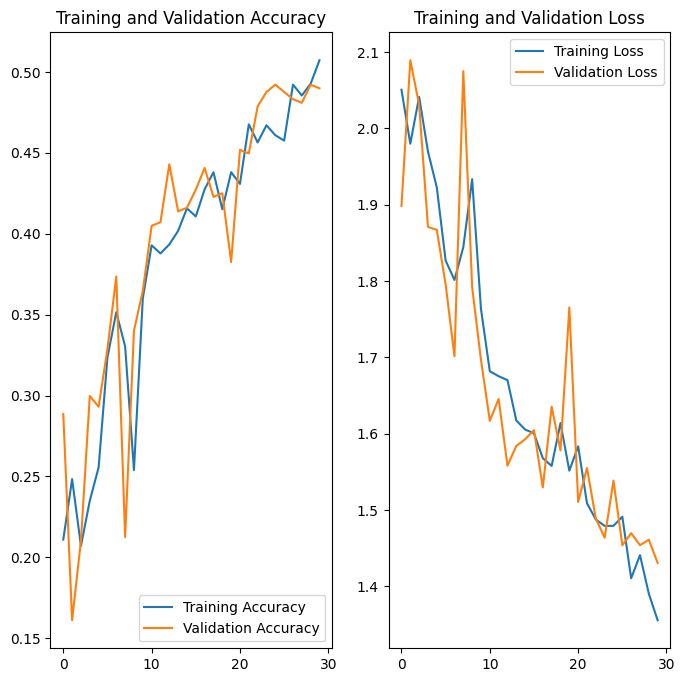

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*italicised text*# findings after the model fit, see if there is an evidence of model overfit or underfit.  there is some improvement now as compared to the previous model run?
Finding from Second Model

There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

We can increase the epochs to increase the accuracy so it's too early for judgement



Find the distribution of classes in the training dataset.
Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
path_list=[]
lesion_list=[]
for i in all_classes_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['path','label'])
original_df

,path,label
0,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,actinic keratosis
1,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,actinic keratosis
2,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,actinic keratosis
3,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,actinic keratosis
4,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,vascular lesion
2235,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,vascular lesion
2236,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,vascular lesion
2237,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,vascular lesion


In [25]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,actinic keratosis
1,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,actinic keratosis
2,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,actinic keratosis
3,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,actinic keratosis
4,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,vascular lesion
2235,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,vascular lesion
2236,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,vascular lesion
2237,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,vascular lesion


<BarContainer object of 9 artists>

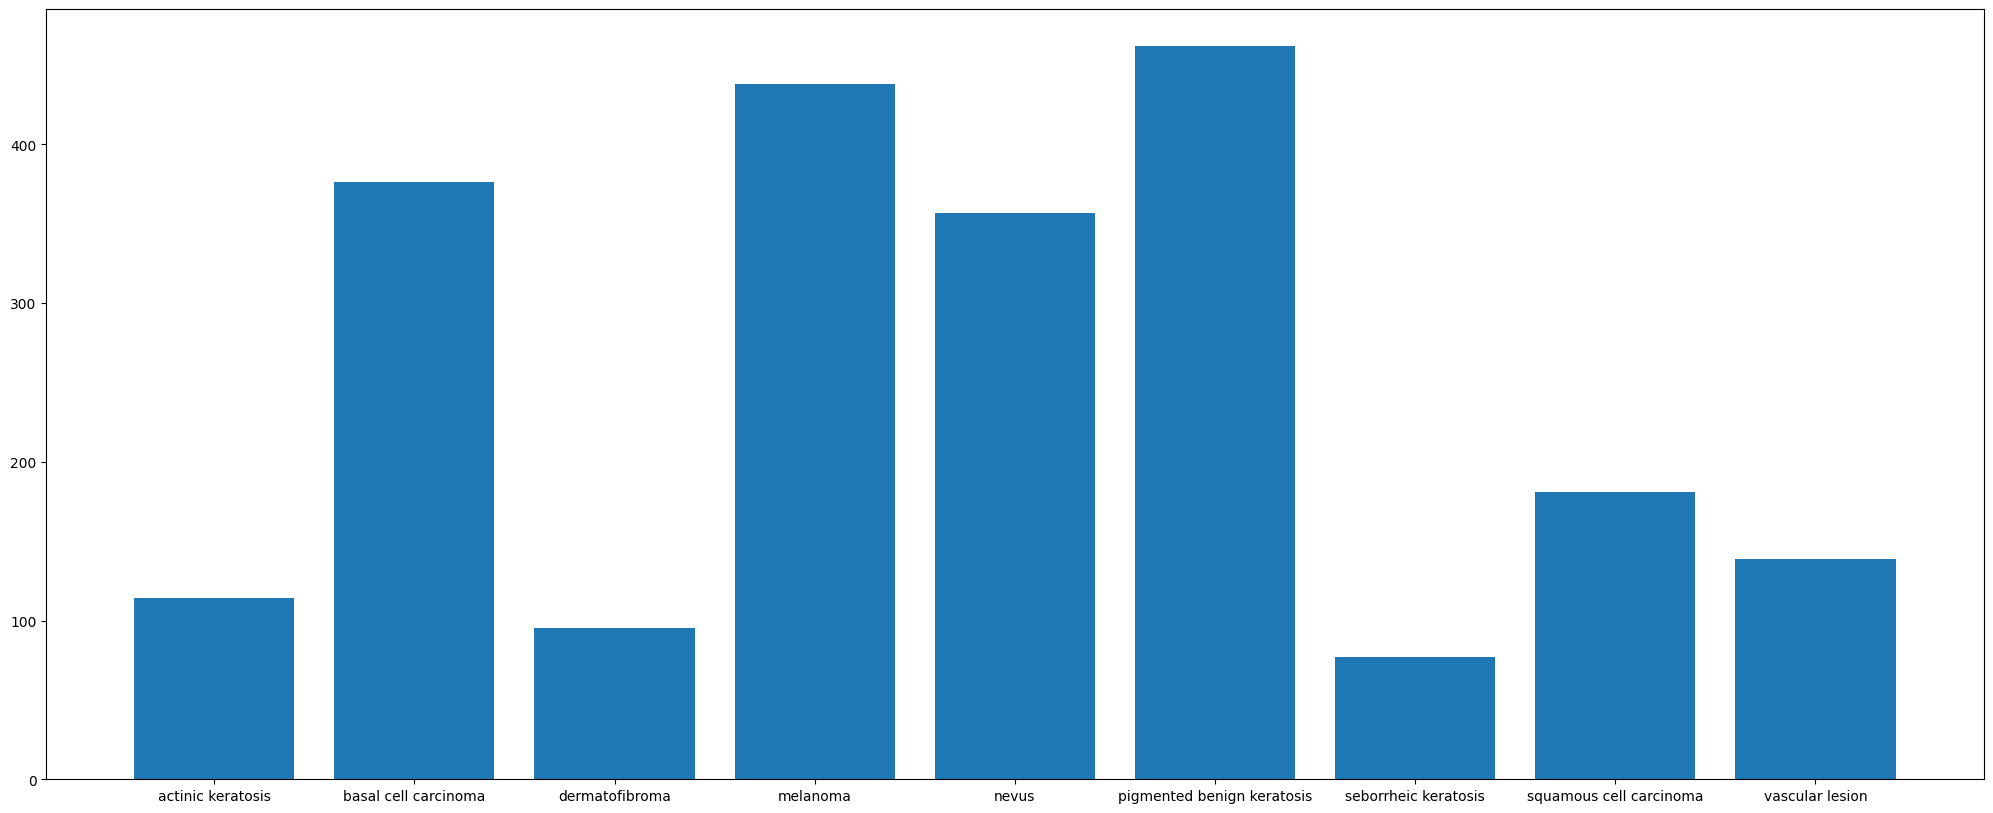

In [26]:
count=[]
for i in all_classes_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(all_classes_names,count)

In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set. Define a number of operations to perform on this data set using your Pipeline object. Execute these operations by calling the Pipeline’s sample() method.

In [28]:
import Augmentor
import os

for i in all_classes_names:
    p = Augmentor.Pipeline("/content/gdrive/MyDrive/ColabNotebooks/Datasets/Skin_Cancer_Data/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/Datasets/Skin_Cancer_Data/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F40D3405190>: 100%|██████████| 500/500 [00:58<00:00,  8.58 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/Datasets/Skin_Cancer_Data/Train/output.

Processing <PIL.Image.Image image mode=RGB size=964x720 at 0x7F40D353EF40>: 100%|██████████| 500/500 [01:00<00:00,  8.26 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/Datasets/Skin_Cancer_Data/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F416CF3B550>: 100%|██████████| 500/500 [01:00<00:00,  8.24 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/Datasets/Skin_Cancer_Data/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F40D33CCD90>: 100%|██████████| 500/500 [00:47<00:00, 10.58 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/Datasets/Skin_Cancer_Data/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7F40D3651940>: 100%|██████████| 500/500 [00:57<00:00,  8.63 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/Datasets/Skin_Cancer_Data/Train/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F40D3538D00>: 100%|██████████| 500/500 [01:00<00:00,  8.22 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/Datasets/Skin_Cancer_Data/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F40DC1B4070>: 100%|██████████| 500/500 [00:55<00:00,  9.09 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/Datasets/Skin_Cancer_Data/Train/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F40D33816A0>: 100%|██████████| 500/500 [00:55<00:00,  8.98 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/Datasets/Skin_Cancer_Data/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F41501216D0>: 100%|██████████| 500/500 [00:53<00:00,  9.43 Samples/s]


In [30]:
data_dir_train1 = pathlib.Path("/content/gdrive/MyDrive/ColabNotebooks/Datasets/Skin_Cancer_Data/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


In [31]:
for i in all_classes_names:
      
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,actinic keratosis
1,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,actinic keratosis
2,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,actinic keratosis
3,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,actinic keratosis
4,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,actinic keratosis
...,...,...
6734,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,vascular lesion
6735,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,vascular lesion
6736,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,vascular lesion
6737,/content/gdrive/MyDrive/ColabNotebooks/Dataset...,vascular lesion


Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
new_df['Label'].value_counts()

pigmented benign keratosis    1408
melanoma                      1316
basal cell carcinoma          1097
nevus                         1080
squamous cell carcinoma        541
vascular lesion                442
actinic keratosis              339
dermatofibroma                 286
seborrheic keratosis           230
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Todo: Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

In [46]:
#data_dir_train1=pathlib.Path("/content/drive/MyDrive/Cancer Detection /Train/output")
data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/ColabNotebooks/Datasets/Skin_Cancer_Data/Train/output")

 Create a training dataset

In [47]:
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


In [49]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/ColabNotebooks/Datasets/Skin_Cancer_Data/Train/output")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [50]:
##Create a validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


# Create your model (make sure to include normalization)

In [51]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

Compile your model (Choose optimizer and loss function appropriately)

In [53]:
## ###code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
epochs =50
## code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
113/113 [==============================] - 26s 194ms/step - loss: 1.9804 - accuracy: 0.2531 - val_loss: 1.8256 - val_accuracy: 0.3078
Epoch 2/50
113/113 [==============================] - 23s 198ms/step - loss: 1.6990 - accuracy: 0.3789 - val_loss: 1.5534 - val_accuracy: 0.4056
Epoch 3/50
113/113 [==============================] - 23s 192ms/step - loss: 1.5347 - accuracy: 0.4603 - val_loss: 1.4638 - val_accuracy: 0.4889
Epoch 4/50
113/113 [==============================] - 23s 196ms/step - loss: 1.4182 - accuracy: 0.4917 - val_loss: 1.5073 - val_accuracy: 0.4833
Epoch 5/50
113/113 [==============================] - 23s 192ms/step - loss: 1.3953 - accuracy: 0.5089 - val_loss: 1.3489 - val_accuracy: 0.5089
Epoch 6/50
113/113 [==============================] - 25s 207ms/step - loss: 1.2439 - accuracy: 0.5528 - val_loss: 1.2081 - val_accuracy: 0.5867
Epoch 7/50
113/113 [==============================] - 23s 193ms/step - loss: 1.1955 - accuracy: 0.5786 - val_loss: 1.2009 - val_ac

Todo: Visualize the model results|

<function matplotlib.pyplot.show(close=None, block=None)>

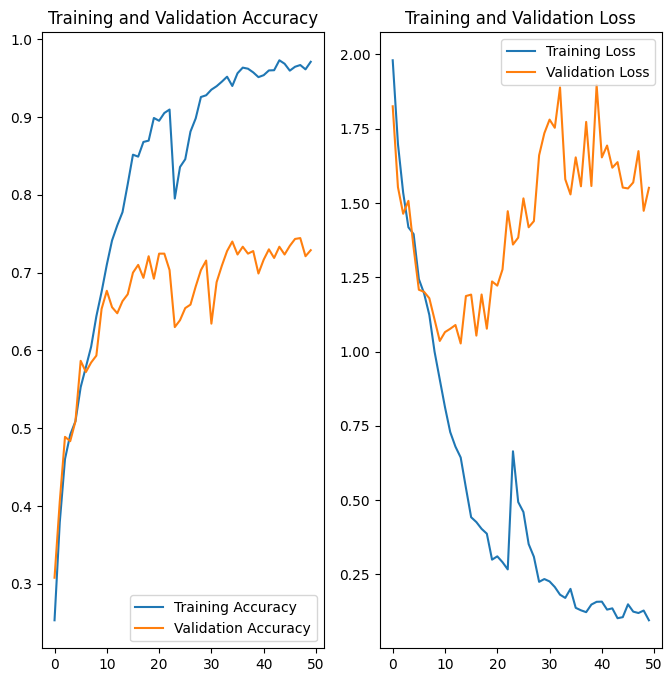

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show

Analyze  results from  here. get rid of underfitting/overfitting. 
Accuracy on training data has increased by using Augmentor library

Model is still overfitting

The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

